# Training the ResNet-18 with CIFAR-10

This notebook trains the ResNet-18 network with the CIFAR-10 dataset in a deterministic fashion and stores the obtained weights.

### 0. Import libraries and define settings

In [1]:
# import Python packages
import os
import time
import random
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

# allow to automatically update the imported modules
%load_ext autoreload
%autoreload 2

In [2]:
# select if the code runs on CPU or GPU
use_cuda = True

if use_cuda and torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


In [3]:
# make PyTorch deterministic
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

[W Context.cpp:70] Warning: torch.use_deterministic_algorithms is in beta, and its design and functionality may change in the future. (function operator())


In [4]:
# define constants
BATCH_SIZE = 128
C, W, H = 3, 32, 32
CLASSES = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

# define model path and name
MODEL_PATH = "./models/"
MODEL_NAME = "baseline_resnet.pth"

### 1. Load and preprocess data

In [5]:
# augment and preprocess train data
transform_train = transforms.Compose(
    [
        transforms.RandomCrop(W, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

trainset = torchvision.datasets.CIFAR10(
    root="./data_cifar", train=True, download=True, transform=transform_train
)

# define the train loader object
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

# augment and preprocess test data
transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

testset = torchvision.datasets.CIFAR10(
    root="./data_cifar", train=False, download=True, transform=transform_test
)

# define the test loader object
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)


Files already downloaded and verified
Files already downloaded and verified


### 2. Define architecture

In [6]:
class ResidualBlock(nn.Module):
    """
    This class defines the architecture of a residual block
    and the function needed to pass the information through it.
    """

    def __init__(self, in_channels, hidden_channels, out_channels):
        """
        Defines the layers used in the block.
        """

        super().__init__()

        self.conv1 = nn.Conv2d(
            in_channels, hidden_channels, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.batch1 = nn.BatchNorm2d(hidden_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(
            hidden_channels,
            out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False,
        )
        self.batch2 = nn.BatchNorm2d(out_channels)

        if in_channels != out_channels:
            self.skip_connection = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels, kernel_size=1, stride=1, bias=False
                ),
                nn.BatchNorm2d(out_channels),
            )
        else:
            self.skip_connection = lambda x: x

    def forward(self, x):
        """
        This method connects the layers into one block.
        """

        skip = self.skip_connection(x)
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.relu(x + skip)

        return x


In [7]:
class ResNet(nn.Module):
    """
    It defines the architecture of the ResNet-18 network.
    """

    def __init__(self, in_channels, out_size):
        """
        This method creates all the layers and initializes the residual blocks.
        """

        super().__init__()

        self.conv1 = nn.Conv2d(
            in_channels, 64, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.batch1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool2d(3, stride=2, padding=1)

        self.res_blocks = nn.ModuleList(
            [
                ResidualBlock(64, 64, 64),
                ResidualBlock(64, 64, 64),
                ResidualBlock(64, 128, 128),
                ResidualBlock(128, 128, 128),
                ResidualBlock(128, 256, 256),
                ResidualBlock(256, 256, 256),
                ResidualBlock(256, 512, 512),
                ResidualBlock(512, 512, 512),
            ]
        )

        self.dense_layer = nn.Linear(512, out_size)

        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(
                    module.weight, mode="fan_out", nonlinearity="relu"
                )

    def forward(self, x):
        """
        Connects the layers and residual blocks.
        """

        x = self.conv1(x)
        x = self.batch1(x)
        x = self.relu(x)
        x = self.pool1(x)
        for block in self.res_blocks:
            x = block.forward(x)
        x = F.avg_pool2d(x, x.shape[2:])

        x = x.view(x.size(0), -1)
        x = self.dense_layer(x)

        return x


### 3. Train the network

In [8]:
# instantiate the network
net = ResNet(C, len(CLASSES)).to(device)

# define the loss function
criterion = nn.CrossEntropyLoss()

# declare the optimization function
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)


In [9]:
# initialize the timer
start = time.time()

# define lists that store train and test accuracy for each epoch
train_acc = []
test_acc = []

for epoch in tqdm(range(0, 2)):

    # initialize number of correct train predictions for the current epoch
    correct_train_total = 0

    net.train()  # Put the network in train mode
    for i, (x_batch, y_batch) in enumerate(trainloader):
        # Move the data to the device that is used
        x_batch, y_batch = x_batch.to(device), y_batch.to(
            device
        )

        # Set all currenly stored gradients to zero
        optimizer.zero_grad()

        y_pred = net(x_batch)

        # compute loss
        loss = criterion(y_pred, y_batch)

        # backpropagate gradients
        loss.backward()

        # apply the optimization step
        optimizer.step()

        # Get the labels with highest output probability
        y_pred_max = torch.argmax(
            y_pred, dim=1
        )

        # Count how many are equal to the true labels
        correct = torch.sum(
            torch.eq(y_pred_max, y_batch)
        ).item()

        # Keep track of how much time has elapsed
        elapsed = time.time() - start

        # Accumulate number of correct predictions
        correct_train_total += correct

        correct_total = 0

    # store train accuracy for current epoch
    train_acc.append(correct_train_total / len(trainset))

    # Put the network in eval mode
    net.eval()

    for i, (x_batch, y_batch) in enumerate(testloader):
        # Move the data to the device that is used
        x_batch, y_batch = x_batch.to(device), y_batch.to(
            device
        )

        # count number of correct predictions
        y_pred = net(x_batch)
        y_pred_max = torch.argmax(y_pred, dim=1)

        correct_total += torch.sum(torch.eq(y_pred_max, y_batch)).item()

    # store test accuracy for current epoch
    test_acc.append(correct_total / len(testset))


100%|██████████| 2/2 [04:04<00:00, 122.42s/it]


### 4. Visualize performance

Train accuracy: 0.6437
Test accuracy: 0.6304


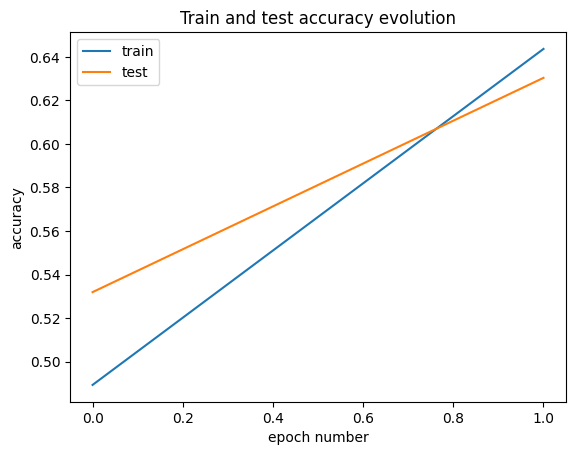

In [10]:
plt.plot(range(len(train_acc)), train_acc)
plt.plot(range(len(test_acc)), test_acc)
plt.legend(["train", "test"])
plt.xlabel("epoch number")
plt.ylabel("accuracy")
plt.title("Train and test accuracy evolution")

print(f"Train accuracy: {train_acc[-1]}\nTest accuracy: {test_acc[-1]}")

### 5. Store and load model

In [11]:
# create a folder for storing the models
if not os.path.exists(MODEL_PATH):
    os.mkdir(MODEL_PATH)

# store the trained model
torch.save(net.state_dict(), MODEL_PATH + MODEL_NAME)

In [12]:
# load the trained model
model = ResNet(C, len(CLASSES)).to(device)
model.load_state_dict(torch.load(MODEL_PATH + MODEL_NAME))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (res_blocks): ModuleList(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Con